<a href="https://colab.research.google.com/github/rajbircit/assignments/blob/main/dl_a2/pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

#### Show the environment

In [2]:
!nvidia-smi
print()
print()
print('=' * 80)
print()
print()
!df -h
print()
print()
print('=' * 80)
print()
print()
!free -m
print()
print()
print('=' * 80)
print()
print()
!lscpu
print()
print()
print('=' * 80)
print()
print()
! ps -eo pmem,pcpu,vsize,pid,cmd | sort -k 1 -nr | head -5


Mon Apr 26 01:41:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Some Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import metrics, model_selection
from statistics import mean, median
from time import perf_counter
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import make_scorer
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn import linear_model
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFwe, chi2, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


#### Setup logging

In [4]:
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import logging
import sys
import random
import matplotlib.pyplot as plt
import os
from google.colab import drive
import shutil
import zipfile
import h5py
import gc
import IPython

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

root = logging.getLogger()
root.setLevel(logging.INFO)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

random.seed(5)
tf.random.set_seed(5)
np.random.seed(5)

#### Mount Google Drive And Copy Files

In [4]:
drive.mount('/content/gdrive')

if (os.path.exists("/root/imagedata")):
    ret = shutil.rmtree("/root/imagedata")
os.mkdir("/root/imagedata")
shutil.copyfile( \
    "/content/gdrive/MyDrive/DeepLearningAssignment2/earth_data.zip",
    "/root/imagedata/earth_data.zip")

!cd /root/imagedata && unzip earth_data.zip && rm -f earth_data.zip

Mounted at /content/gdrive
Archive:  earth_data.zip
  inflating: earth_data.h5           


## Code to plot graphs and remember histories

In [5]:
class Entry:
    def __init__(self, loss, val_loss, accuracy, val_accuracy, best_accuracy, best_loss):
        self.loss = loss
        self.val_loss = val_loss
        self.accuracy = accuracy
        self.val_accuracy = val_accuracy
        self.best_accuracy = best_accuracy
        self.best_loss = best_loss

class Plot:
    def __init__(self):
        self.history = {}
        self.colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:blue', \
                       'tab:orange', 'tab:green', 'tab:red', 'tab:purple', \
                       'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']

    def plot_history(self, history, N_EPOCHS, name, show=True):
        if show:
            N_EPOCHS = len(history.history["loss"])
            plt.rcParams["figure.figsize"] = (20, 10)
            plt.xticks(np.arange(0, N_EPOCHS+1, 1.0))
            plt.plot(np.arange(0, N_EPOCHS), history.history["loss"], label="train loss", color='blue', linestyle='solid')
            plt.plot(np.arange(0, N_EPOCHS), history.history["val_loss"], label="val loss", color='blue', linestyle='dashdot')
            plt.plot(np.arange(0, N_EPOCHS), history.history["accuracy"], label="train acc", color='red', linestyle='solid')
            plt.plot(np.arange(0, N_EPOCHS), history.history["val_accuracy"], label="val acc", color='red', linestyle='dashdot')
            plt.legend()
            plt.show()
        best_val_acc = max(history.history['val_accuracy'])
        index_best_val_accuracy = history.history['val_accuracy'].index(best_val_acc)
        best_val_loss = min(history.history['val_loss'])
        index_best_val_loss = history.history['val_loss'].index(best_val_loss)
        if show:
            print(f"Best validation accuracy: {best_val_acc}, epoch = {index_best_val_accuracy}")
            print(f"Best validation loss: {best_val_loss}, epoch = {index_best_val_loss}")
        entry = Entry(\
                      loss=history.history["loss"],\
                      val_loss=history.history["val_loss"],\
                      accuracy=history.history["accuracy"],\
                      val_accuracy=history.history["val_accuracy"],\
                      best_accuracy=best_val_acc,
                      best_loss=best_val_loss)
        self.history[name] = entry
        gc.collect()

    def superplot(self):
        i = 0
        plt.rcParams["figure.figsize"] = [30, 10]
        fig, ax = plt.subplots(1, 2)
        def innerplot(self, ax, arr, text, linest):
            ax.plot(np.arange(0, len(arr)), arr, label=text, color=self.colors[i], linestyle=linest)
        for name, entry in self.history.items():
            innerplot(self, ax[0], entry.loss, f"{name}-loss", "solid")
            innerplot(self, ax[0], entry.val_loss, f"{name}-val-loss", "dashdot")
            innerplot(self, ax[1], entry.accuracy, f"{name}-accuracy", "solid")
            innerplot(self, ax[1], entry.val_accuracy, f"{name}-val-accuracy", "dashdot")
            i += 1
        ax[0].legend()
        ax[1].legend()
        plt.show()



## Extract train and test instances

In [6]:
def loadDataH5():
    with h5py.File('/root/imagedata/earth_data.h5','r') as hf:
        trainX = np.array(hf.get('trainX'))
        trainY = np.array(hf.get('trainY'))
        valX = np.array(hf.get('valX'))
        valY = np.array(hf.get('valY'))
        print (trainX.shape,trainY.shape)
        print (valX.shape,valY.shape)
        return trainX, trainY, valX, valY

trainX, trainY, valX, valY = loadDataH5()
trainX = trainX / 255.0
valX = valX / 255.0

(19200, 64, 64, 3) (19200,)
(4800, 64, 64, 3) (4800,)


## Callbacks

In [13]:
def decay_after_runs(N):
    NRUNS = N
    # We're sneaking this in, since this will be called at every epoch
    # it also gives us a good way to force calls to gc() within the fit function
    gc.collect()
    def learning_rate_scheduler(epoch, lr):
        if NRUNS < 0 or epoch < NRUNS:
            return lr
        else:
            print(f"Learning Rate: {lr} --> {lr * tf.math.exp(-1.0)}")
            return lr * tf.math.exp(-0.1)
    return learning_rate_scheduler
lr_callback = tf.keras.callbacks.LearningRateScheduler(decay_after_runs(20))

early_stopping = tf.keras.callbacks.EarlyStopping(\
                                                  monitor='val_loss',\
                                                  patience=3,
                                                  verbose=1,
                                                  mode='auto')
early_stopping2 = tf.keras.callbacks.EarlyStopping(\
                                                  monitor='val_loss',\
                                                  patience=10,
                                                  verbose=1,
                                                  mode='auto')


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(\
                                                 monitor='val_loss',\
                                                 factor=0.5,\
                                                 patience=3,\
                                                 min_lr=0.001)

term_on_nan = tf.keras.callbacks.TerminateOnNaN()

DRIVE_FOLDER = "/content/gdrive/MyDrive/DeepLearningAssignment2"

def get_checkpoint_filepath(name):
    return f"{DRIVE_FOLDER}/ckp-{name}"
    
def get_checkpoint_callback(name):
    checkpoint_filepath = f"{DRIVE_FOLDER}/ckp-{name}"
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    return model_checkpoint_callback


def get_callbacks_decay_after(N, name=None):
    if N == -2:
        callback_array = [\
                        tf.keras.callbacks.LearningRateScheduler(\
                                                    decay_after_runs(-1)),
                        early_stopping2,
                        term_on_nan,
                        ]
    else:
        callback_array = [\
                        tf.keras.callbacks.LearningRateScheduler(\
                                                    decay_after_runs(N)),
                        early_stopping,
                        term_on_nan,
                        ]
    if N > 0:
        callback_array.append(reduce_lr)
    if None != name:
        callback_array.append(get_checkpoint_callback(name))
    return callback_array

## 1. Load the VGG Model


In [ ]:
vgg = tf.keras.applications.VGG16(\
                                  include_top=False,\
                                  weights='imagenet',\
                                  input_shape=trainX[0].shape)

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
print(vgg.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [ ]:
import pandas as pd
import seaborn as sns
gc.collect()

from sklearn.pipeline import Pipeline
import time

def feature_extraction_test(\
                            model_name:str,\
                            model,\
                            trainX,\
                            trainY,\
                            valX,\
                            valY
                            ):
    def secondary_classification(\
                                 model,\
                                 trainX,\
                                 trainY,\
                                 valX,\
                                 valY):
        model.fit(trainX, trainY)
        y_pred = model.predict(valX)
        return accuracy_score(valY, y_pred)

    basic_models = [
        ('DecisionTreeClassifier', lambda: Pipeline([('pca', PCA(n_components=50),), ('dt', DecisionTreeClassifier(random_state=1),)])),
        ('KNeighborsClassifier', lambda: Pipeline([('pca', PCA(n_components=100),), ('knn', KNeighborsClassifier(n_jobs=-1),)])),
        ('NearestCentroid', lambda: Pipeline([('pca', PCA(n_components=100),), ('nearestCentroid', NearestCentroid(),)])),
        ('NaiveBayes', lambda: GaussianNB()),
        ('SVC', lambda: Pipeline([('pca', PCA(n_components=200),), ('svc', SVC(random_state=1),)])),
        ('Random Forest', lambda: RandomForestClassifier(random_state=1, n_jobs=-1)),
        #('Gradient Boost', lambda: Pipeline([('pca', PCA(n_components=25),), ('gb',GradientBoostingClassifier(),)])),
        ('LDA', lambda: Pipeline([('pca', PCA(n_components=20),), ('lda', LinearDiscriminantAnalysis(),)])),
        ('QDA', lambda: Pipeline([('pca', PCA(n_components=20),), ('qda',QuadraticDiscriminantAnalysis(),)])),
        ('Logistic Regression', lambda: LogisticRegression(random_state=1, n_jobs=-1)),
        ('Ridge', lambda: Pipeline([('pca', PCA(n_components=50),), ('rc',RidgeClassifier(random_state=1),)])),
        ('Bagging', lambda: Pipeline([('pca', PCA(n_components=100),), ('bg', BaggingClassifier(random_state=1, n_jobs=-1),)])),
        #('SGD Classifier', lambda: Pipeline([('pca', PCA(n_components=100),), ('sgd', SGDClassifier(random_state=1),)])),
        ('SGD Classifier', lambda: SGDClassifier(random_state=1, n_jobs=-1, max_iter=2000)),
        ('Passive Aggressive', lambda: Pipeline([('pca', PCA(n_components=50),),('pac', PassiveAggressiveClassifier(random_state=1, n_jobs=-1),)])),
    ]

    m_names = []
    m_acc = []
    t_trainX = model.predict(trainX)
    t_valX = model.predict(valX)
    t_trainX = t_trainX.reshape(t_trainX.shape[0], -1)
    t_valX = t_valX.reshape(t_valX.shape[0], -1)
    scaler = StandardScaler().fit(t_trainX)
    t_trainX = scaler.transform(t_trainX)
    t_valX = scaler.transform(t_valX)

    for (n, m) in basic_models:
        gc.collect()
        print(f"Training model {n}")
        t1 = time.perf_counter()
        accuracy = secondary_classification(m(),\
                                            t_trainX,\
                                            trainY,\
                                            t_valX,\
                                            valY)
        t2 = time.perf_counter()
        print(f"Accuracy = {accuracy:0.3f}, \t\t\t\tTime taken = {(t2 - t1):2.2f}s")
        m_names.append(n)
        m_acc.append(accuracy)
        
    df = pd.DataFrame({"Model": pd.Series(m_names), "accuracy": pd.Series(m_acc)})
    p = sns.barplot(y='Model', x='accuracy', data=df, orient='h')
    p.set_title(model_name)
    plt.show()
    return m_names, m_acc

    


Training model DecisionTreeClassifier
Accuracy = 0.643, 				Time taken = 4.84s
Training model KNeighborsClassifier
Accuracy = 0.777, 				Time taken = 15.46s
Training model NearestCentroid
Accuracy = 0.653, 				Time taken = 4.15s
Training model NaiveBayes
Accuracy = 0.502, 				Time taken = 0.69s
Training model SVC
Accuracy = 0.840, 				Time taken = 61.29s
Training model Random Forest
Accuracy = 0.817, 				Time taken = 23.25s
Training model LDA
Accuracy = 0.700, 				Time taken = 2.60s
Training model QDA
Accuracy = 0.677, 				Time taken = 2.63s
Training model Logistic Regression
Accuracy = 0.851, 				Time taken = 32.56s
Training model Ridge
Accuracy = 0.732, 				Time taken = 3.12s
Training model Bagging
Accuracy = 0.758, 				Time taken = 19.84s
Training model SGD Classifier
Accuracy = 0.855, 				Time taken = 156.50s
Training model Passive Aggressive
Accuracy = 0.751, 				Time taken = 3.38s


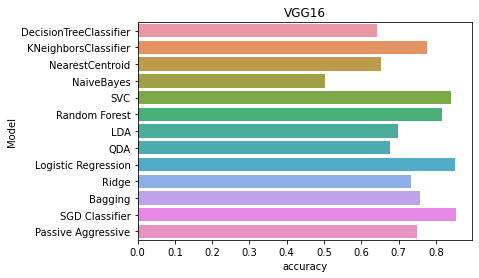

In [ ]:
vgg16 = tf.keras.applications.VGG16(\
                                  include_top=False,\
                                  weights='imagenet',\
                                  input_shape=trainX[0].shape)
vg16_names, vgg16_acc = feature_extraction_test("VGG16", vgg16, trainX, trainY, valX, valY)


80142336/80134624 [==============================] - 0s 0us/step
Training model DecisionTreeClassifier
Accuracy = 0.611, 				Time taken = 4.77s
Training model KNeighborsClassifier
Accuracy = 0.741, 				Time taken = 13.39s
Training model NearestCentroid
Accuracy = 0.617, 				Time taken = 4.21s
Training model NaiveBayes
Accuracy = 0.470, 				Time taken = 0.81s
Training model SVC
Accuracy = 0.804, 				Time taken = 65.18s
Training model Random Forest
Accuracy = 0.776, 				Time taken = 26.67s
Training model LDA
Accuracy = 0.659, 				Time taken = 2.72s
Training model QDA
Accuracy = 0.633, 				Time taken = 2.62s
Training model Logistic Regression
Accuracy = 0.816, 				Time taken = 31.89s
Training model Ridge
Accuracy = 0.689, 				Time taken = 3.15s
Training model Bagging
Accuracy = 0.719, 				Time taken = 19.96s
Training model SGD Classifier
Accuracy = 0.816, 				Time taken = 191.48s
Training model Passive Aggressive
Accuracy = 0.689, 				Time taken = 3.41s


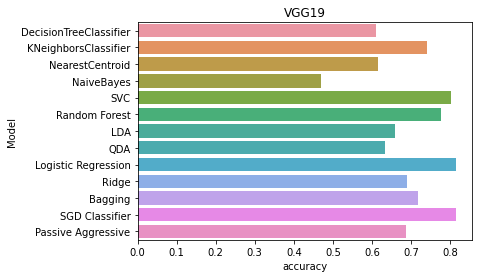

In [ ]:
gc.collect()
vgg19 = tf.keras.applications.VGG19(\
                                    include_top=False,\
                                    weights='imagenet',\
                                    input_shape=trainX[0].shape)
vgg19_names, vgg19_acc = feature_extraction_test("VGG19",\
                                                 vgg19,\
                                                 trainX,\
                                                 trainY,\
                                                 valX,\
                                                 valY)

94674944/94668760 [==============================] - 1s 0us/step
Training model DecisionTreeClassifier
Accuracy = 0.564, 				Time taken = 11.36s
Training model KNeighborsClassifier
Accuracy = 0.700, 				Time taken = 28.20s
Training model NearestCentroid
Accuracy = 0.639, 				Time taken = 13.51s
Training model NaiveBayes
Accuracy = 0.510, 				Time taken = 2.75s
Training model SVC
Accuracy = 0.801, 				Time taken = 86.28s
Training model Random Forest
Accuracy = 0.755, 				Time taken = 30.38s
Training model LDA
Accuracy = 0.625, 				Time taken = 7.80s
Training model QDA
Accuracy = 0.554, 				Time taken = 7.78s
Training model Logistic Regression
Accuracy = 0.814, 				Time taken = 321.76s
Training model Ridge
Accuracy = 0.704, 				Time taken = 9.98s
Training model Bagging
Accuracy = 0.662, 				Time taken = 29.56s
Training model SGD Classifier
Accuracy = 0.820, 				Time taken = 343.09s
Training model Passive Aggressive
Accuracy = 0.677, 				Time taken = 9.96s


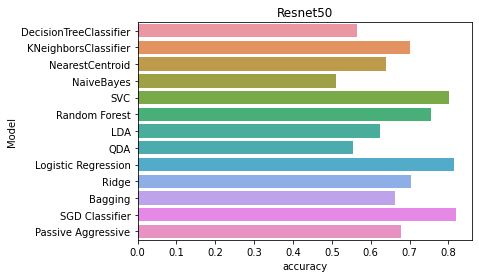

In [ ]:
gc.collect()
resnet50 = tf.keras.applications.ResNet50V2(\
                                          include_top=False,\
                                          weights='imagenet',\
                                          input_shape=trainX[0].shape)
                               
resnet50_names, resnet50_acc = feature_extraction_test(\
                                                       "Resnet50",\
                                                       resnet50,\
                                                       trainX,\
                                                       trainY,\
                                                       valX,\
                                                       valY)

74842112/74836368 [==============================] - 0s 0us/step
Training model DecisionTreeClassifier
Accuracy = 0.690, 				Time taken = 10.43s
Training model KNeighborsClassifier
Accuracy = 0.854, 				Time taken = 22.79s
Training model NearestCentroid
Accuracy = 0.734, 				Time taken = 11.90s
Training model NaiveBayes
Accuracy = 0.710, 				Time taken = 3.18s
Training model SVC
Accuracy = 0.922, 				Time taken = 60.97s
Training model Random Forest
Accuracy = 0.837, 				Time taken = 90.21s
Training model LDA
Accuracy = 0.792, 				Time taken = 6.95s
Training model QDA
Accuracy = 0.798, 				Time taken = 6.77s
Training model Logistic Regression
Accuracy = 0.927, 				Time taken = 125.69s
Training model Ridge
Accuracy = 0.855, 				Time taken = 9.00s
Training model Bagging
Accuracy = 0.784, 				Time taken = 30.34s
Training model SGD Classifier
Accuracy = 0.917, 				Time taken = 95.20s
Training model Passive Aggressive
Accuracy = 0.819, 				Time taken = 8.96s


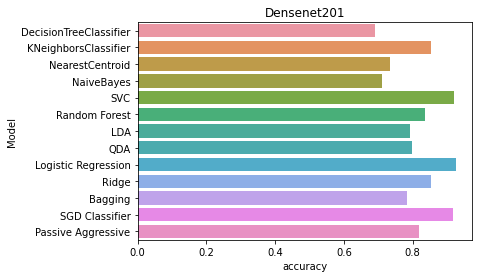

In [ ]:
gc.collect()
densenet = tf.keras.applications.DenseNet201(\
                                  include_top=False,\
                                  input_shape=trainX[0].shape)
densenet_names, densenet_acc = feature_extraction_test(\
                                                       "Densenet201",\
                                                       densenet,\
                                                       trainX,\
                                                       trainY,\
                                                       valX,\
                                                       valY)

  Pretrained Model  DecisionTreeClassifier  KNeighborsClassifier  \
0            VGG16                0.643125              0.777500   
1            VGG19                0.611250              0.741042   
2         ResNet50                0.563542              0.700208   
3         DenseNet                0.690208              0.853542   

   NearestCentroid  NaiveBayes       SVC  Random Forest       LDA       QDA  \
0         0.653333    0.502292  0.840208       0.816667  0.699792  0.677500   
1         0.616667    0.470417  0.803750       0.775833  0.659375  0.633125   
2         0.639375    0.509583  0.801250       0.755208  0.625000  0.554167   
3         0.734375    0.710000  0.921667       0.836875  0.791875  0.797917   

   Logistic Regression     Ridge   Bagging  SGD Classifier  Passive Aggressive  
0             0.851458  0.732083  0.758333        0.855208            0.750625  
1             0.816458  0.688750  0.719167        0.816250            0.688542  
2             0.8137

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


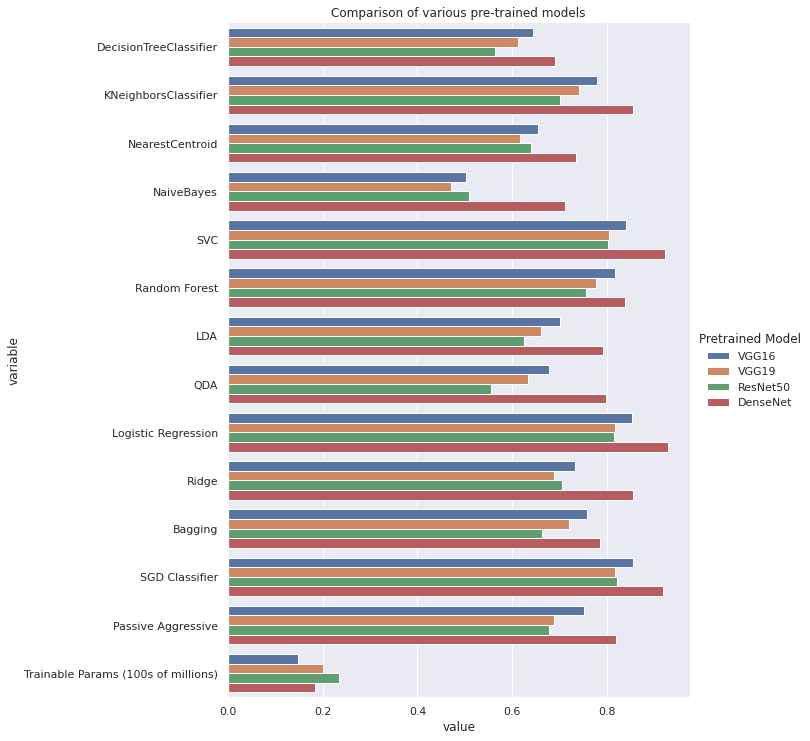

In [ ]:
gc.collect()
def compare_pretrained_models():
    def pretty_print(x):
        dfs = pd.DataFrame(x)
        pd.set_option('display.max_columns', None)
        print(dfs)
    classifier_names = densenet_names
    models = [vgg16, vgg19, resnet50, densenet]
    accuracies = [vgg16_acc, vgg19_acc, resnet50_acc, densenet_acc]
    pretrained=['VGG16', 'VGG19', 'ResNet50', 'DenseNet']
    data = {}
    data["Pretrained Model"] = pretrained
    for i, name in enumerate(classifier_names):
        arr = []
        for acc_arr in accuracies:
            arr.append(acc_arr[i])
        data[name] = arr
    pretty_print(data)

    parameters = [m.count_params() / (100_000_000) for m in models]
    data["Trainable Params (100s of millions)"] = parameters
    dfs = pd.DataFrame(data)
    dfs1 = pd.melt(dfs, id_vars="Pretrained Model")
    print(dfs1)
    sns.set(rc={'figure.figsize':(20, 15,)})
    p = sns.factorplot(hue="Pretrained Model", x='value', y='variable', data=dfs1, kind='bar', size=10, orient='h')
    plt.title('Comparison of various pre-trained models')
    plt.show()


compare_pretrained_models()

# Fine Tune

In [11]:
def combine_and_train_finetune(\
                               model1,\
                               model2,\
                               trainX,\
                               trainY,\
                               valX,\
                               valY,\
                               nepochs,
                               layer_to_unfreeze):
    combined = tf.keras.Sequential()
    model1.trainable = False
    combined.add(model1)
    combined.add(model2)

    logging.info("Phase 1 starting...")
    opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    combined.compile(optimizer=opt,\
                     loss='sparse_categorical_crossentropy',\
                     metrics=['accuracy'])
    plot = Plot()
    history = combined.fit(trainX, trainY, \
                    validation_data=(valX, valY),\
                    batch_size=32,\
                    epochs=nepochs,\
                    callbacks=get_callbacks_decay_after(-1, combined.name))
    plot.plot_history(history, nepochs, "combined")
    plt.show()
    logging.info("OK.")

    logging.info("Phase 2 starting...")
    model1.trainable = True
    trainableFlag = False
    for layer in model1.layers:
        if layer.name == layer_to_unfreeze:
            trainableFlag = True
        layer.trainable = trainableFlag
    opt = tf.keras.optimizers.RMSprop(learning_rate=1.0e-5)
    combined.compile(optimizer=opt,\
                     loss='sparse_categorical_crossentropy',\
                     metrics=['accuracy'])
    history = combined.fit(trainX, trainY, \
                    validation_data=(valX, valY),\
                    batch_size=32,\
                    epochs=nepochs,
                    callbacks=get_callbacks_decay_after(-1, combined.name))
    logging.info("OK.")

    return combined

   

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

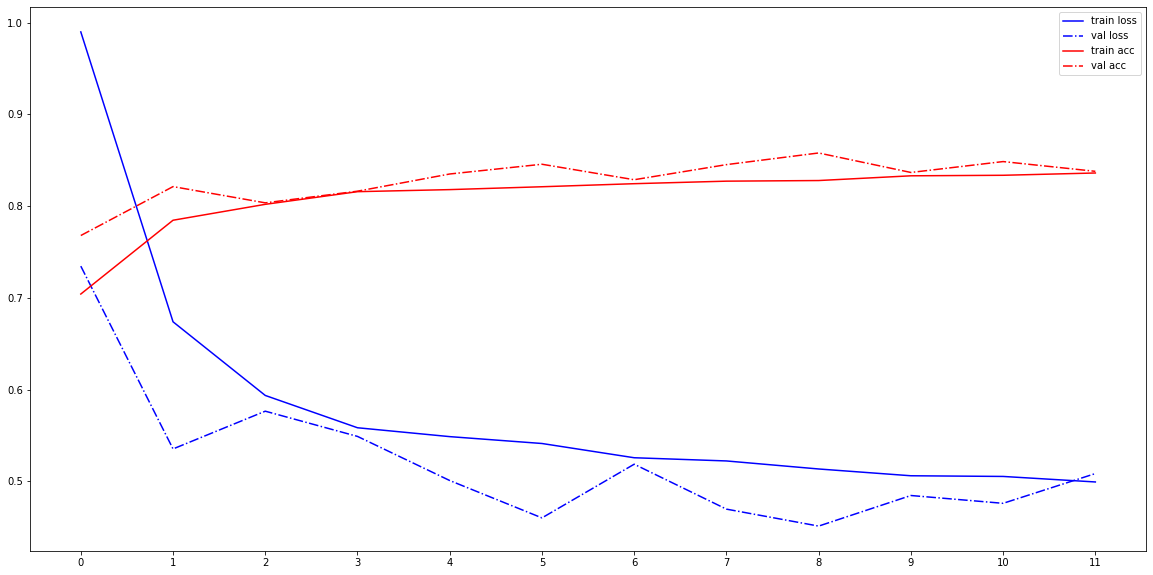

Best validation accuracy: 0.8579166531562805, epoch = 8
Best validation loss: 0.4511149227619171, epoch = 8
2021-04-26 01:36:15,373 - root - INFO - OK.
2021-04-26 01:36:15,375 - root - INFO - Phase 2 starting...
Epoch 1/25
600/600 [==============================] - 23s 36ms/step - loss: 0.4119 - accuracy: 0.8638 - val_loss: 0.4364 - val_accuracy: 0.8679
Epoch 2/25
600/600 [==============================] - 21s 35ms/step - loss: 0.2590 - accuracy: 0.9112 - val_loss: 0.2959 - val_accuracy: 0.9035
Epoch 3/25
600/600 [==============================] - 21s 35ms/step - loss: 0.1872 - accuracy: 0.9395 - val_loss: 0.3088 - val_accuracy: 0.9073
Epoch 4/25
600/600 [==============================] - 21s 35ms/step - loss: 0.1447 - accuracy: 0.9511 - val_loss: 0.3020 - val_accuracy: 0.9194
Epoch 5/25
600/600 [==============================] - 21s 35ms/step - loss: 0.1185 - accuracy: 0.9607 - val_loss: 0.2817 - val_accuracy: 0.9171
Epoch 6/25
600/600 [==============================] - 21s 35ms/step 

In [12]:
import IPython

n_classes = len(np.unique(np.concatenate((trainY, valY))))
class ShallowNet:
    @staticmethod
    def build(inshape, nlabels):
        model = tf.keras.Sequential(name="BaseLineShallowNet")
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dropout(rate=0.25))
        model.add(tf.keras.layers.Dense(512))
        model.add(tf.keras.layers.Dropout(rate=0.25))
        model.add(tf.keras.layers.Dense(nlabels, activation='softmax'))
        return model

vgg16 = tf.keras.applications.VGG16(\
                                  include_top=False,\
                                  weights='imagenet',\
                                  input_shape=trainX[0].shape)
vgg16.trainable = False
print(vgg16.summary())

myModel = ShallowNet.build(vgg16.output_shape, n_classes)

combined_model = combine_and_train_finetune(vgg16, myModel, trainX, trainY, valX, valY, 25, 'block4_conv2')

In [14]:
gc.collect()

180

In [17]:
!ps | grep -i python
! ps -eo pmem,pcpu,vsize,pid,cmd | sort -k 1 -nr | head -5

     57 ?        00:05:33 python3
     77 ?        00:00:01 python3
    254 ?        00:00:00 python3
88.4 59.6 46543936    57 /usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-36e8ca50-2420-42b5-9815-3dd0fadd27a8.json
 0.4  1.7 2465000    201 /opt/google/drive/drive --features=fuse_max_background:1000,max_read_qps:1000,max_write_qps:1000,max_operation_batch_size:15,max_parallel_push_task_instances:10,opendir_timeout_ms:120000,virtual_folders_omit_spaces:true --inet_family=IPV4_ONLY --preferences=trusted_root_certs_file_path:/opt/google/drive/roots.pem,mount_point_path:/content/gdrive --console_auth --auto_restart_count=1 --first_auto_restart_timestamp=551 --single_process --parent_version=46.0.3.0 --crash_handler_token=dummy_crash_token
 0.4  0.9 195188      46 /usr/bin/python2 /usr/local/bin/jupyter-notebook --ip="172.28.0.2" --port=9000 --FileContentsManager.root_dir="/" --LargeFileManager.delete_to_trash=False --MappingKernelManager.root_dir="/cont

In [ ]:
!kill -9 57

In [1]:
os.getpid()

NameError: ignored